## Logistic Regression with a Neural Network mindset
### 1 使用到的包
1. numpy 是python里面基础的关于向量计算的包
2. h5py 是一种常见的用来与存放在h5文件中的数据集交互的包
3. matplotlib 是著名的用python绘图的包
4. PIL和SciPy是用来测试你的模型，用你自己的照片在最后。
5. 至于另外一个lr_utils是自己写的模块，用来处理数据集的，python中，文件名就是模块名，只要把文件放在工作目录下，就可以当成库引用


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset  
%matplotlib inline

lr_utils.py文件内容：
```python
import numpy as np
import h5py
    
def load_dataset():
    train_dataset = h5py.File('./datasets/train_cat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_cat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
```

### 2 关于数据集的预览，以及.h5文件说明

In [44]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

每一个图像的维度都是(num_px, num_px, 3)，其中，长宽相同，3表示是RGB图像。

train_set_x_orig和test_set_x_orig中，包含`_orig`是由于我们稍候需要对图像进行预处理，预处理后的变量将会命名为train_set_x和train_set_y。
 通过lr_utils.py模块的load_dataset()方法加载好.h5文件里的数据之后，我们知道train_set_x_orig是所有图像文件的特征数据，这些数据都被存放到train_set_x_orig数组中了，通过查看这个数组的维度发现，    print train_set_x_orig.shape  运行结果为(209L, 64L, 64L, 3L)，得出这个数组中存放的数据是209个样本的图片，图片的维度为`64*64`大小的,即分别对应一个图片的(height, width, 3)。3表示图像的通道数


1
y = [1], it's a 'cat' picture.


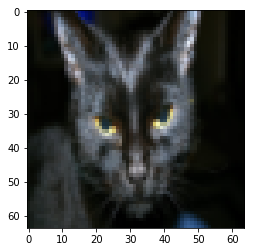

In [45]:
# Example of a picture
index = 25
print (np.squeeze(train_set_y[:, index]))
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [46]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [47]:


# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))   #整形后的检查，输出展开后的前5位数，看看是不是整形成功

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


原本关于训练测试的x表示的4维数组，现在要将左右的图片的`64*64*3`的亮度值，3个维度转换为一个维度，那么train_set_x原本的四个维度(样本数，高，宽，通道数)就应该reshape为(`高*宽*3`特征值个数，通道数)
A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗c ∗ d, a) is to use:
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

![关于reshape方法参数-1的例子](http://upload-images.jianshu.io/upload_images/1779926-a4dc51b6dc2f1def.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

下一步：标准化数据
机器学习中的一个共同的预处理步骤是中心和规范你的数据，这意味着要减去所有数的平均值对于数组中的每个数，然后把每个数都除以整个NumPy数组的标准偏差。但是对于图片数据集来说，它更简单，更方便，几乎只需要将数据集的每一行划分为255（像素信道的最大值）。
让我们标准化我们的数据集。

In [48]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

需要记住的是：
通常对于一个新的数据集的预处理工作是：
1. 弄清楚问题的维度以及数据的形状，即数据的内容
2. 整形数据，对数据的形状，例如图像文件是用的三个维度的数据表示的现在改为一个维度，将所有特征值装在一个向量中
3. 标准化数据

### 3 机器学习的一般结构
接下来我们设计一个简单的算法来区别猫图还是非猫图
你会用到逻辑回归以及神经网络模式，接下来的图片解释了为什么逻辑回归实际上就是一个简单的神经网络。
![逻辑回归是个简单的神经网络](http://upload-images.jianshu.io/upload_images/1779926-50cbe961dae39a13.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

![算法相关数学表达公式](http://upload-images.jianshu.io/upload_images/1779926-fc6805ce36e1f4f4.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
其中比较关键的步骤：
1. 初始化模型参数
2. 学习参数通过最小化成本
3. 使用学习到的参数做预测
4. 分析结果并且下结论

### 4 构建算法
创建一个神经网络的关键步骤：
1. 定义模型的结构（例如输入的特征数量）
2. 初始化模型的参数
3. 循环：
···计算当前的成本（前向传播）
···计算当前梯度（反向传播）
···更新参数（使用梯度下降法）

#### 4.1 辅助函数
  首先实现sigmoid()函数，以及需要计算`w*x+b`

In [49]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1.0 / (1.0 + np.exp(-z ))
    ### END CODE HERE ###
    
    return s

In [50]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [ 0.5         0.88079708]


#### 4.2 初始化参数
需要初始化w为一个全是0的向量，使用np.zeros()方法

In [51]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))   
    b = 0
    """
    注意如果参数只有dim则是一个秩为1的数组，而我们现在想初始化成一个dim行一列的列向量
    """
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [52]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[ 0.]
 [ 0.]]
b = 0


#### 4.3 前向传播和反向传播
现在，参数都已经被初始化好了，那么就可以通过前向和反向传播来学习参数了。
接下来任务，实现propagate()方法来计算成本和梯度。
![关于前向和反向传播中的公式](http://upload-images.jianshu.io/upload_images/1779926-4fd41ab7c503bdaf.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)


In [53]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X)+b )                                   # compute activation 
    cost = -np.sum(np.dot(np.log(A),Y.T)+np.dot(np.log(1.0-A),(1.0-Y).T))/m                   # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1.0/m* np.dot(X,(A-Y).T)
    db = 1.0/m* np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [54]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99993216]
 [ 1.99980262]]
db = 0.499935230625
cost = 6.00006477319


优化：
    你已经初始化参数了，并且也得到了成本和梯度，现在，你需要通过梯度下降法来更新参数
练习： 编写优化函数，目标是学习w和b最小化成本函数J。 
For a parameterθ, the update rule is  θ=θ−α dθ=θ−α dθ , where α is the learning rate.

In [55]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    params为最后习得的参数更新后的值组成的字典
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    grads 为当前迭代更新后，成本函数J对这两个参数的全局梯度值
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    成本——优化期间计算的所有成本的列表，这将用于绘制学习曲线。
    
   您基本上需要写下两个步骤并进行迭代：
   1）计算当前参数的成本和梯度。使用propagate()。
   2）利用梯度下降规则对w和b进行参数更新。
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)

        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b- learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [56]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 0.1124579 ]
 [ 0.23106775]]
b = 1.55930492484
dw = [[ 0.90158428]
 [ 1.76250842]]
db = 0.430462071679


练习：前面的函数会输出学习后的w和b，我们可以使用w和b来预测对于新的数据集X的标签，接下来实现predict()函数。
这里有两个步骤来计算预测：

![根据学习后的w和b预测的两个步骤](http://upload-images.jianshu.io/upload_images/1779926-69bbc75e7c1c32df.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)
即首先计算最后是猫图的概率，即通过激活函数得出的概率结果，最后将结果转换为0或1,0表示算出概率小于0.5， 大于0.5则表示为1，把这些预测的结果存储到Y_prediction向量中。你可以使用if-else在for循环里面，不过这里同样也可以使用向量化技术。

In [57]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X)+b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0,i]>=0.5:
            Y_prediction[0,i]=1
        else:
             Y_prediction[0,i]=0
        pass
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [58]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 1.  1.]]


记住你已经实现了很多个函数了：
    初始化(w,b)
    反复迭代优化成本并且学习了参数(w,b)
        计算成本和梯度
        使用梯度下降法更新参数
    使用学习到的(w,b)来预测给的其他训练样本


### 5 合并所有的算法到一个模型
练习：关于整个逻辑回归需要用到的公式计算步骤上面的格子已经都基本实现了，接下来实现整体模型，并且得到下面的输出内容：
1. Y_prediction 对于测试集的预测结果
2. Y_prediction_train 对于新联集上的预测结果
3. w, costs, grads 等作为优化函数optimize()的输出

In [59]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w,b,X_train, Y_train,num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    ### END CODE HERE ###

    # Print train/test Errors  输出最后训练或测试错误率
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [60]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


点评：训练数据集的正确率接近100%，这是一个良好的健全检查 ：你的模型应该工作有足够高的能力让所有的训练数据集都符合。测试数据集的错误率为30%，这个简单的模型实际上并不坏，因为我们使用的小数据集和logistic回归是一个线性分类器。但别担心，下周你会建立一个更好的分类器！
另外，你看到的模型显然是过度拟合训练数据。后来在这个专业，你将学习如何减少过拟合，例如利用正则化。使用下面的代码（并更改索引变量），您可以查看测试集的图片预测。

y = [1], you predicted that it is a "cat" picture.


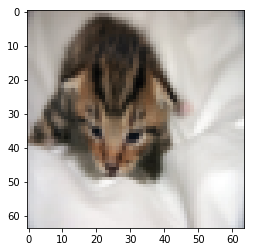

In [61]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3))) 
print ("y = " + str(test_set_y[:,index])+ ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

在上一步，这里遇到了问题，其中问题可能出在，老师代码使用的python3，并且在d["Y_prediction_test"]向量中，0,1都是浮点数，不是整形，所以无法在classes里面找到对应的是猫还是不是猫。注意，这些问题都可以先使用print的方式打印出部分内容，一个个检查是否符合想要的结果。

[0.69314718055994529, 0.58450836369930859, 0.46694904094655476, 0.37600686694802121, 0.33146328932825125, 0.30327306747438287, 0.27987958658260492, 0.26004213692587574, 0.24294068467796648, 0.22800422256726055, 0.21481951378449654, 0.20307819060644999, 0.19254427716706829, 0.183033337968835, 0.17439859438448882, 0.16652139705400335, 0.15930451829756614, 0.15266732471296507, 0.14654223503982347, 0.14087207570310165]


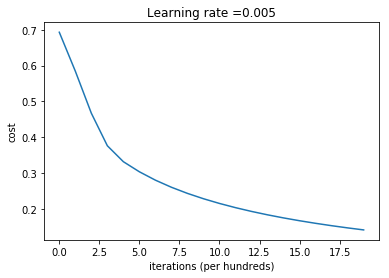

In [62]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

提示: 此处需要提示的一个地方，有可能画不出来结果，并且每一百次打印一次cost值，发现后面的cost值都为nan，关于这个原因，代码会提示在log函数中会有0的参数以及在exp函数中发生了溢出，解决办法可以是，修改学习率的值，老师给出的代码中学习率是0.5，学习率太大的话导致一次梯度下降步长太大，取不到局部最优值，同时也可能使得中间的计算也出现精度等的错误，因此建议修改学习率为0.005。

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



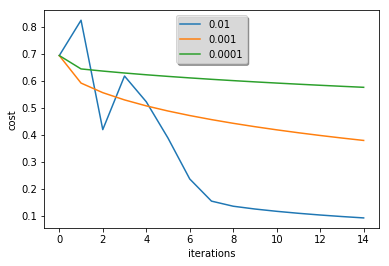

In [66]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

解释：你可以看到成本下降。这表明参数正在被学习。然而，你看到你可以在训练集中更有效地训练这个模型。尝试在上面的单元格中增加迭代次数，然后重新运行单元格。您可能会看到训练集的精确度提高了，但是测试集的精确度下降了。这就是所谓的过拟合。

### 6 长远分析
检查可能的选择对于学习率α
提醒：为了使梯度下降工作，你必须明智地选择学习率。学习率α决定如何迅速我们更新参数。如果学习速率太大，我们可能会“超过”最佳值。类似地，如果它太小，我们需要太多迭代来收敛到最佳值。这就是为什么要使用一个调整良好的学习率的关键。

让我们比较我们的模型的学习曲线和几种学习速率的选择。运行下面的单元格。这大约需要1分钟放轻松，尝试其他不同的值除了已经初始化的三个学习率，看看会发生什么。

解释：
不同的学习率会带来不同的成本，从而产生不同的预测结果。
如果学习率太大（0.01），成本可能会上下波动。它甚至可能发散（虽然在这个例子中，使用0.01仍然最终以一个很好的代价）。
较低的成本并不意味着更好的模式。你必须检查是否有可能过度拟合。当训练精度远远高于测试精度时会发生这种情况。
在深入学习中，我们通常推荐你：
1. 选择更好地降低成本函数的学习率。
2. 如果你的模型overfits，使用其他技术来减少过度拟合。

### 7 用你自己的图片来测试


y = 1.0, your algorithm predicts a "cat" picture.


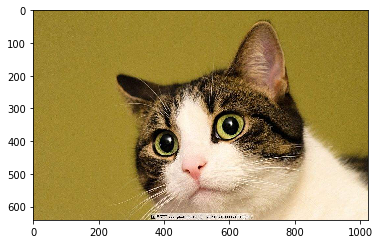

In [64]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "img1.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


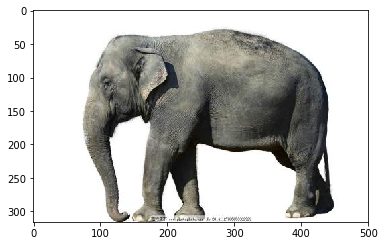

In [65]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "img2.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")